If you run in jupyter, turn

```
colab = False
```



In [1]:
colab = True
if colab:
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !apt-get update > /dev/null 2>&1
    !apt-get install cmake > /dev/null 2>&1
    !pip install --upgrade setuptools 2>&1
    !pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/day2_q_learning
    !ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/day2_q_learning
assets			      optimum.npy	     schedule.py
chap3_tabular_q_learning.pdf  optimum.png	     table.npy
compare.py		      plot.py		     table.py
discrete_pendulum.py	      __pycache__	     test.py
learned_value.png	      q_learning_full.ipynb  trajectory.png
main.py			      q_learning.ipynb	     video


# Tabular Q-learning Practice

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from gym.envs.registration import register
from discrete_pendulum import DiscretePendulumEnv
register(
    id="DiscretePendulum-v1",
    entry_point="discrete_pendulum:DiscretePendulumEnv",
    max_episode_steps=200,
)

# 0. Basic definitions

## 0.0. Q-table

In [4]:
class QTable:
    def __init__(self, num_states, num_actions, gamma=0.99, pth=None):
        self.gamma = gamma
        if pth is None:
            self.Q = -300. * np.ones(shape=(num_states, num_actions))
        else:
            self.Q = np.load(pth, allow_pickle=True)

    def update(self, state, action, reward, next_state, alpha):
        # update Q-table according to the following update rule:
        # Q(s, a) <- Q(s, a) + alpha * (r + gamma * max_a' {Q(s', a')} - Q(s, a))
        # TODO_1 : Implement update target of Q-function, r + gamma * max_a' {Q(s', a')} - Q(s, a).
        target = reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state, action]
        # TODO_2 : Build incremental update of Q-function.
        self.Q[state, action] += alpha * target

    def act(self, state):
        # TODO_3 : Using Q-table, choose a greedy action.
        return np.argmax(self.Q[state])

    def save(self, pth=None):
        if pth is None:
            pth = './table.npy'
        np.save(pth, self.Q)

    @property
    def value_ftn(self):
        return np.max(self.Q, axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 0.1. Stepsize rule & Exploration Schedule

In [5]:
class LinearExplorationSchedule:
    def __init__(self, rollout_len, initial_epsilon=1., final_epsilon=0.02):
        # linear exploration schedule
        self.decrement = (initial_epsilon - final_epsilon) / rollout_len
        self.initial_epsilon = initial_epsilon
        self.final_epsilon = final_epsilon

    def __call__(self, t):
        # Define this as callable object so that the schedule is stateless.
        return max(self.initial_epsilon - t * self.decrement, self.final_epsilon)

# TODO_optional : try exponentially decaying schedule!
class ExponentialExplorationSchedule:
    def __init__(self, decay_rate, initial_epsilon=1., final_epsilon=0.02):
        self.decay_rate = decay_rate
        self.initial_epsilon = initial_epsilon
        self.final_epsilon = final_epsilon

    def __call__(self, t):
        epsilon = self.decay_rate ** t * self.initial_epsilon
        return max(epsilon, self.final_epsilon)

# 1. Q-learning

In [6]:
env = DiscretePendulumEnv()
num_states = env.observation_space.n
num_actions = env.action_space.n
gamma = 0.99

learner = QTable(num_states=env.observation_space.n, num_actions=env.action_space.n, gamma=gamma)
rollout_len = 4000000


epsilon_schedule = LinearExplorationSchedule(rollout_len, final_epsilon=0.5)
# TODO_optional : alternative schedule
# epsilon_schedule = ExponentialExplorationSchedule(decay_rate=0.99, final_epsilon=0.02)

checkpoint_interval = rollout_len // 20

In [7]:
class VisitCountStepsizeSchedule:
    def __init__(self, deg=1.0):
        # polynomial stepsize schedule : $\Theta(N_t(s, a)^{-d})$
        # $N_t(s, a)$ is the number of visits of (s, a)-pair until step t
        # to satisfy Robbins-Monro condition, d must satisfy $d \in (1/2, 1]$
        assert .5 < deg <= 1
        self.deg = deg

    def __call__(self, n):
        return 1. / ((n + 1.) ** self.deg)

visit_count = np.zeros(shape=(num_states, num_actions))     # save visit counts N(s, a) of all state-action pairs
alpha_schedule = VisitCountStepsizeSchedule(deg=0.5001)

s = env.reset()
for t in tqdm(range(rollout_len + 1)):
    u = np.random.rand()    # sampling from uniform distribution [0, 1)
    # TODO_4 : Implement epsilon-greedy algorithm (random action with probability epsilon, greedy action with probability 1 - epsilon).
    if u < epsilon_schedule(t):
        a = env.action_space.sample()
    else:
        a = learner.act(state=s)

    # TODO_5 : Using the chosen action, get the next state and reward.
    s_next, r, _, _ = env.step(action=a)

    n = visit_count[s, a]
    # TODO_6 : Update Q-table with QTable.update().
    learner.update(state=s, action=a, reward=r, next_state=s_next, alpha=alpha_schedule(n))

    visit_count[s, a] += 1
    s = s_next

    if t % checkpoint_interval == 0:
        learner.save()

100%|██████████| 4000001/4000001 [20:49<00:00, 3202.11it/s]


# 2. Let's see if the Q-function is learned properly!

## 2.0. Visualization

In [8]:
import gym
from gym.wrappers.record_video import RecordVideo
import os
from IPython.display import HTML
from base64 import b64encode

In [9]:
#Install classical control environment
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
ep_len = 400
# test learned result!
trajectory = np.zeros((ep_len, 2))      # store continuous states
reward = 0.

np.random.seed(2023)

# Make directory of video record.
os.makedirs('./video',exist_ok=True)

# TODO_7 : Make gym environment with id 'DiscretePendulum-v1'.
env = gym.make('DiscretePendulum-v1')
env = RecordVideo(env=env, video_folder='./video', name_prefix='pendulum_trained_control')

s = env.reset(deterministic=True)

env.start_video_recorder()
for t in range(ep_len):
    trajectory[t] = np.copy(env.x)
    # TODO_8 : Execute only greedy action at test time.
    a = learner.act(s)
    s, r, _, _ = env.step(a)
    # TODO_9 : Compute cumulative reward = sum_t {gamma^t * r}.
    reward += (gamma ** t) * r
print('total reward =', reward)

# Close environment and video record.
env.close_video_recorder()

mp4 = open('./video/pendulum_trained_control-episode-0.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/day2_q_learning/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym ver

total reward = -697.1935153774546


## 2.1. Trajectory Plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


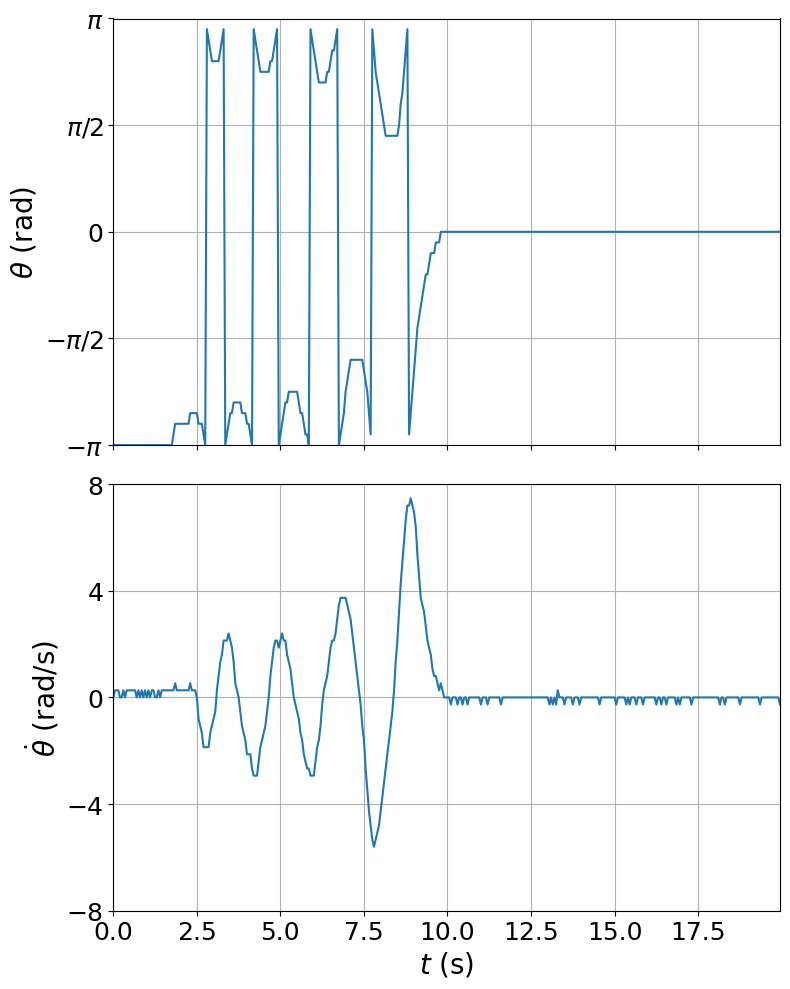

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
x = env.dt * np.arange(ep_len)
ylabels = [r'$\theta$ (rad)', r'$\dot\theta$ (rad/s)']
ax[1].set_xlabel(r'$t$ (s)', fontsize=20)
ax[0].set_ylim(-np.pi, np.pi)
ax[1].set_ylim(-8., 8.)
ax[0].set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax[0].set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax[1].set_yticks([-8, -4, 0, 4, 8])
for i in range(2):
    ax[i].plot(x, trajectory[:, i])
    ax[i].set_xlim(0, x[-1])
    ax[i].grid(True)
    ax[i].set_ylabel(ylabels[i], fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=18)
fig.tight_layout()

# 2.2. Q-learning Result vs Optimal Solution

In [12]:
optimal_agent = QTable(num_states=env.observation_space.n, num_actions=env.action_space.n, pth='./optimum.npy')

env = gym.make('DiscretePendulum-v1')
env = RecordVideo(env=env, video_folder='./video', name_prefix='pendulum_optimal_control')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/day2_q_learning/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [13]:
ep_len = 400
# test learned result!
trajectory = np.zeros((ep_len, 2))      # store continuous states
reward = 0.

s = env.reset(deterministic=True)
env.start_video_recorder()
for t in range(ep_len):
    trajectory[t] = np.copy(env.x)
    a = optimal_agent.act(s)
    s, r, _, _ = env.step(a)
    reward += (gamma ** t) * r

print('total reward =', reward)
env.close_video_recorder()

mp4 = open('./video/pendulum_optimal_control-episode-0.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment DiscretePendulum-v1 initialized with `render_mode=None` is marked as deprecated

total reward = -201.34967130825746
